<a href="https://colab.research.google.com/github/sushassassin/VAC_ImageProcessing/blob/main/VAC_Mini_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Neural Network Embedding Recommendation System
In this notebook, we will build a book recommendation system based on a simple principle: books with Wikipedia pages that link to similar Wikipedia pages are similar to each other. In order to create this representation of similar books, we'll use the concept of neural network entity embeddings, mapping each book and each Wikipedia link (Wikilink) to a 50-number vector.

To create entity embeddings, we need to build an embedding neural network and train it on a supervised machine learning task that will result in similar books (and similar links) having closer representations in embedding space. The parameters of the neural network - the weights - are the embeddings, and so during training, these numbers are adjusted to minimize the loss on the prediction problem. In other words, the network tries to accurately complete the task by changing the representations of the books and the links.

Once we have the embeddings for the books and the links, we can find the most similar book to a given book by computing the distance between the embedded vector for that book and all the other book embeddings. We'll use the cosine distance which measures the angle between two vectors as a measure of similarity (another valid option is the Euclidean distance). We can also do the same with the links, finding the most similar page to a given page. (I use links and wikilinks interchangeably in this notebook). The steps we will follow are:

1.Load in data and clean
2.Prepare data for supervised machine learning task
3.Build the entity embedding neural network
4.Train the neural network on prediction task
5.Extract embeddings and find most similar books and wikilinks
6.Visualize the embeddings using dimension reduction techniques



(Took Help From Will Koehrsen on kaggle)

In [3]:
!pip install keras


In [1]:
from IPython.core.interactiveshell import InteractiveShell

# Set shell to show all lines of output
InteractiveShell.ast_node_interactivity = 'all'

In [5]:
from tensorflow.keras.utils import get_file

x = get_file('found_books_filtered.ndjson', 'https://raw.githubusercontent.com/WillKoehrsen/wikipedia-data-science/master/data/found_books_filtered.ndjson')

import json

books = []

with open(x, 'r') as fin:
    # Append each line to the books
    books = [json.loads(l) for l in fin]

# Remove non-book articles
books_with_wikipedia = [book for book in books if 'Wikipedia:' in book[0]]
books = [book for book in books if 'Wikipedia:' not in book[0]]
print(f'Found {len(books)} books.')

58941440/58925764 [==============================] - 0s 0us/step
Found 37020 books.


In [6]:
[book[0] for book in books_with_wikipedia][:5]

['Wikipedia:Wikipedia Signpost/2014-06-25/Recent research',
 'Wikipedia:New pages patrol/Unpatrolled articles/December 2010',
 'Wikipedia:Templates for discussion/Log/2012 September 23',
 'Wikipedia:Articles for creation/Redirects/2012-10',
 'Wikipedia:Templates for discussion/Log/2012 October 4']

In [7]:
n = 21
books[n][0], books[n][1], books[n][2][:5], books[n][3][:5], books[n][3][:5], books[n][4], books[n][5]

('Limonov (novel)',
 {'author': 'Emmanuel Carrère',
  'country': 'France',
  'english_pub_date': '2014',
  'isbn': '978-2-8180-1405-9',
  'language': 'French',
  'name': 'Limonov',
  'pages': '488',
  'pub_date': '2011',
  'publisher': 'P.O.L.',
  'translator': 'John Lambert'},
 ['Emmanuel Carrère',
  'biographical novel',
  'Emmanuel Carrère',
  'Eduard Limonov',
  'Prix de la langue française'],
 ['http://www.lefigaro.fr/flash-actu/2011/10/05/97001-20111005FILWWW00615-le-prix-de-la-langue-francaise-a-e-carrere.php',
  'http://www.lexpress.fr/culture/livre/emmanuel-carrere-prix-renaudot-2011_1046819.html',
  'http://limonow.de/carrere/index.html',
  'http://www.tout-sur-limonov.fr/222318809'],
 ['http://www.lefigaro.fr/flash-actu/2011/10/05/97001-20111005FILWWW00615-le-prix-de-la-langue-francaise-a-e-carrere.php',
  'http://www.lexpress.fr/culture/livre/emmanuel-carrere-prix-renaudot-2011_1046819.html',
  'http://limonow.de/carrere/index.html',
  'http://www.tout-sur-limonov.fr/222318

In [8]:
book_index = {book[0]: idx for idx, book in enumerate(books)}
index_book = {idx: book for book, idx in book_index.items()}

book_index['Anna Karenina']
index_book[22494]

22494

'Anna Karenina'

In [9]:
from itertools import chain

wikilinks = list(chain(*[book[2] for book in books]))
print(f"There are {len(set(wikilinks))} unique wikilinks.")

There are 311276 unique wikilinks.


In [10]:
wikilinks_other_books = [link for link in wikilinks if link in book_index.keys()]
print(f"There are {len(set(wikilinks_other_books))} unique wikilinks to other books.")

There are 17032 unique wikilinks to other books.


In [11]:
from collections import Counter, OrderedDict

def count_items(l):
    """Return ordered dictionary of counts of objects in `l`"""
    
    # Creating a counter object
    counts = Counter(l)
    
    # Sorting by highest count first and place in ordered dictionary
    counts = sorted(counts.items(), key = lambda x: x[1], reverse = True)
    counts = OrderedDict(counts)
    
    return counts

In [12]:
# Finding set of wikilinks for each book and convert to a flattened list
unique_wikilinks = list(chain(*[list(set(book[2])) for book in books]))

wikilink_counts = count_items(unique_wikilinks)
list(wikilink_counts.items())[:10]

[('Hardcover', 7489),
 ('Paperback', 7311),
 ('Wikipedia:WikiProject Books', 6043),
 ('Wikipedia:WikiProject Novels', 6015),
 ('English language', 4185),
 ('United States', 3060),
 ('Science fiction', 3030),
 ('The New York Times', 2727),
 ('science fiction', 2502),
 ('novel', 1979)]

In [13]:
wikilinks = [link.lower() for link in unique_wikilinks]
print(f"There are {len(set(wikilinks))} unique wikilinks.")

wikilink_counts = count_items(wikilinks)
list(wikilink_counts.items())[:10]

There are 297624 unique wikilinks.


[('paperback', 8740),
 ('hardcover', 8648),
 ('wikipedia:wikiproject books', 6043),
 ('wikipedia:wikiproject novels', 6016),
 ('science fiction', 5665),
 ('english language', 4248),
 ('united states', 3063),
 ('novel', 2983),
 ('the new york times', 2742),
 ('fantasy', 2003)]

In [14]:
to_remove = ['hardcover', 'paperback', 'hardback', 'e-book', 'wikipedia:wikiproject books', 'wikipedia:wikiproject novels']
for t in to_remove:
    wikilinks.remove(t)
    _ = wikilink_counts.pop(t)

In [15]:
# Limiting to greater than 3 links
links = [t[0] for t in wikilink_counts.items() if t[1] >= 4]
print(len(links))


41758


In [16]:
# Finding set of book wikilinks for each book
unique_wikilinks_books = list(chain(*[list(set(link for link in book[2] if link in book_index.keys())) for book in books]))

# Counting the number of books linked to by other books
wikilink_book_counts = count_items(unique_wikilinks_books)
list(wikilink_book_counts.items())[:10]

[('The Encyclopedia of Science Fiction', 127),
 ('The Discontinuity Guide', 104),
 ('The Encyclopedia of Fantasy', 63),
 ('Dracula', 55),
 ('Encyclopædia Britannica', 51),
 ('Nineteen Eighty-Four', 51),
 ('Don Quixote', 49),
 ('The Wonderful Wizard of Oz', 49),
 ("Alice's Adventures in Wonderland", 47),
 ('Jane Eyre', 39)]

In [17]:
for book in books:
    if 'The New York Times' in book[2] and 'New York Times' in book[2]:
        print(book[0], book[2])
        break

The Big Picture: Who Killed Hollywood? and Other Essays ['Wikipedia:WikiProject Novels', 'Wikipedia:WikiProject Books', 'William Goldman', 'United States', 'English language', 'William Goldman', 'Michael Sragow', 'Good Will Hunting', 'Robin Williams', 'Matt Damon', 'The New York Times', 'The New York Times Company', 'New York Times', 'Category:Cinema of the United States', 'Category:Film production', 'Category:2000 books', 'Category:Books about films', 'Category:Books by William Goldman', 'Category:Show business memoirs']


In [18]:
wikilink_counts.get('the new york times')
wikilink_counts.get('new york times')

2742

996

In [19]:
link_index = {link: idx for idx, link in enumerate(links)}
index_link = {idx: link for link, idx in link_index.items()}

link_index['the economist']
index_link[300]
print(f'There are {len(link_index)} wikilinks that will be used.')

300

'the economist'

There are 41758 wikilinks that will be used.


In [20]:
pairs = []

# Iterating through each book
for book in books:
    # Iterating through the links in the book
    pairs.extend((book_index[book[0]], link_index[link.lower()]) for link in book[2] if link.lower() in links)
    
len(pairs), len(links), len(books)
pairs[5000]

(772798, 41758, 37020)

(321, 232)

In [21]:
index_book[pairs[5000][0]], index_link[pairs[5000][1]]

('Slaves in the Family', 'category:american biographies')

In [22]:
index_book[pairs[900][0]], index_link[pairs[900][1]]

('The Man Who Watched the Trains Go By (novel)',
 'category:belgian novels adapted into films')

In [23]:
pairs_set = set(pairs)

In [24]:
x = Counter(pairs)
sorted(x.items(), key = lambda x: x[1], reverse = True)[:5]

[((13337, 31112), 85),
 ((31899, 65), 77),
 ((25899, 8850), 61),
 ((1851, 2629), 57),
 ((25899, 30465), 53)]

In [25]:
index_book[13337], index_link[31111]
index_book[31899], index_link[65]
index_book[25899], index_link[30465]

("France's Songs of the Bards of the Tyne - 1850", 'robert nunn (songwriter)')

('The Early Stories: 1953–1975', 'the new yorker')

('Marthandavarma (novel)', 'kerala sahitya akademi')

In [26]:
import numpy as np
import random
random.seed(100)

def generate_batch(pairs, n_positive = 50, negative_ratio = 1.0, classification = False):
    """Generate batches of samples for training"""
    batch_size = n_positive * (1 + negative_ratio)
    batch = np.zeros((batch_size, 3))
    
    # Adjusting label based on task
    if classification:
        neg_label = 0
    else:
        neg_label = -1
    
    # This creates a generator
    while True:
        # randomly choose positive examples
        for idx, (book_id, link_id) in enumerate(random.sample(pairs, n_positive)):
          batch[idx, :] = (book_id, link_id, 1)
           # Increment idx by 1
        idx += 1
        
        # Adding negative examples until reach batch size
        while idx < batch_size:
            
            # random selection
            random_book = random.randrange(len(books))
            random_link = random.randrange(len(links))
            
            # Checking to make sure this is not a positive example
            if (random_book, random_link) not in pairs_set:
                
                # Adding to batch and increment index
                batch[idx, :] = (random_book, random_link, neg_label)
                idx += 1
                
        # Making sure to shuffle order
        np.random.shuffle(batch)
        yield {'book': batch[:, 0], 'link': batch[:, 1]}, batch[:, 2]

In [27]:
next(generate_batch(pairs, n_positive = 2, negative_ratio = 2))

({'book': array([29814., 28410.,  7206., 22162., 25757.,  6895.]),
  'link': array([11452., 33217., 34924.,  5588., 22920.,   260.])},
 array([-1., -1., -1.,  1., -1.,  1.]))

In [28]:
x, y = next(generate_batch(pairs, n_positive = 2, negative_ratio = 2))

# Showing a few example training pairs
for label, b_idx, l_idx in zip(y, x['book'], x['link']):
    print(f'Book: {index_book[b_idx]:30} Link: {index_link[l_idx]:40} Label: {label}') 

Book: The Counterfeit Man            Link: gerald gardner (wiccan)                  Label: -1.0
Book: Soul Music (novel)             Link: peter crowther                           Label: -1.0
Book: Des Imagistes                  Link: august strindberg                        Label: -1.0
Book: The Soul of the Robot          Link: category:house of night series           Label: -1.0
Book: Bag of Bones                   Link: category:novels by stephen king          Label: 1.0
Book: Deep Six (novel)               Link: president of the united states           Label: 1.0


In [29]:
#Neural Network Embedding Model
from keras.layers import Input, Embedding, Dot, Reshape, Dense
from keras.models import Model

In [33]:
def book_embedding_model(embedding_size = 50, classification = False):
    """Model to embed books and wikilinks using the functional API.
       Trained to discern if a link is present in a article"""
    
    # Both inputs are 1-dimensional
    book = Input(name = 'book', shape = [1])
    link = Input(name = 'link', shape = [1])
    
    # Embedding the book (shape will be (None, 1, 50))
    book_embedding = Embedding(name = 'book_embedding',
                               input_dim = len(book_index),
                               output_dim = embedding_size)(book)
    
    # Embedding the link (shape will be (None, 1, 50))
    link_embedding = Embedding(name = 'link_embedding',
                               input_dim = len(link_index),
                               output_dim = embedding_size)(link)
                               # Merge the layers with a dot product along the second axis (shape will be (None, 1, 1))
    merged = Dot(name = 'dot_product', normalize = True, axes = 2)([book_embedding, link_embedding])
    
    # Reshape to be a single number (shape will be (None, 1))
    merged = Reshape(target_shape = [1])(merged)
    
    # If classifcation, add extra layer and loss function is binary cross entropy
    if classification:
        merged = Dense(1, activation = 'sigmoid')(merged)
        model = Model(inputs = [book, link], outputs = merged)
        model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    # Otherwise loss function is mean squared error
    else:
        model = Model(inputs = [book, link], outputs = merged)
        model.compile(optimizer = 'Adam', loss = 'mse')
    
    return model


# Instantiate model and show parameters
model = book_embedding_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 book (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 link (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 book_embedding (Embedding)     (None, 1, 50)        1851000     ['book[0][0]']                   
                                                                                                  
 link_embedding (Embedding)     (None, 1, 50)        2087900     ['link[0][0]']                   
                                                                                              

In [34]:
#Train Model
n_positive = 1024

gen = generate_batch(pairs, n_positive, negative_ratio = 2)

# Train
h = model.fit_generator(gen, epochs = 15, 
                        steps_per_epoch = len(pairs) // n_positive,
                        verbose = 2)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


754/754 - 42s - loss: 0.9552 - 42s/epoch - 56ms/step
Epoch 2/15
754/754 - 38s - loss: 0.7045 - 38s/epoch - 51ms/step
Epoch 3/15
754/754 - 37s - loss: 0.5015 - 37s/epoch - 49ms/step
Epoch 4/15
754/754 - 38s - loss: 0.4623 - 38s/epoch - 50ms/step
Epoch 5/15
754/754 - 39s - loss: 0.4448 - 39s/epoch - 52ms/step
Epoch 6/15
754/754 - 38s - loss: 0.4355 - 38s/epoch - 51ms/step
Epoch 7/15
754/754 - 38s - loss: 0.4292 - 38s/epoch - 51ms/step
Epoch 8/15
754/754 - 38s - loss: 0.4251 - 38s/epoch - 51ms/step
Epoch 9/15
754/754 - 38s - loss: 0.4218 - 38s/epoch - 50ms/step
Epoch 10/15
754/754 - 38s - loss: 0.4195 - 38s/epoch - 51ms/step
Epoch 11/15
754/754 - 38s - loss: 0.4168 - 38s/epoch - 50ms/step
Epoch 12/15
754/754 - 38s - loss: 0.4153 - 38s/epoch - 50ms/step
Epoch 13/15
754/754 - 38s - loss: 0.4134 - 38s/epoch - 51ms/step
Epoch 14/15
754/754 - 39s - loss: 0.4124 - 39s/epoch - 51ms/step
Epoch 15/15
754/754 - 38s - loss: 0.4109 - 38s/epoch - 51ms/step


In [36]:
model.save('first_attempt.h5')

In [37]:
book_layer = model.get_layer('book_embedding')
book_weights = book_layer.get_weights()[0]
book_weights.shape

(37020, 50)

In [38]:
book_weights = book_weights / np.linalg.norm(book_weights, axis = 1).reshape((-1, 1))
book_weights[0][:10]
np.sum(np.square(book_weights[0]))

array([-0.15111557, -0.07631215, -0.12797518, -0.13293289,  0.26382062,
        0.06937243,  0.05540038, -0.12585191, -0.0605666 ,  0.17389649],
      dtype=float32)

1.0000001

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 15

def find_similar(name, weights, index_name = 'book', n = 10, least = False, return_dist = False, plot = False):
    """Find n most similar items (or least) to name based on embeddings. Option to also plot the results"""
    
    # Select index and reverse index
    if index_name == 'book':
        index = book_index
        rindex = index_book
    elif index_name == 'page':
        index = link_index
        rindex = index_link
    
    # Check to make sure `name` is in index
    try:
        # Calculate dot product between book and all others
        dists = np.dot(weights, weights[index[name]])
    except KeyError:
        print(f'{name} Not Found.')
        return
    
    # Sort distance indexes from smallest to largest
    sorted_dists = np.argsort(dists)
    
    # Plot results if specified
    if plot:
        
        # Find furthest and closest items
        furthest = sorted_dists[:(n // 2)]
        closest = sorted_dists[-n-1: len(dists) - 1]
        items = [rindex[c] for c in furthest]
        items.extend(rindex[c] for c in closest)
        
        # Find furthest and closets distances
        distances = [dists[c] for c in furthest]
        distances.extend(dists[c] for c in closest)
        
        colors = ['r' for _ in range(n //2)]
        colors.extend('g' for _ in range(n))
        
        data = pd.DataFrame({'distance': distances}, index = items)
        
        # Horizontal bar chart
        data['distance'].plot.barh(color = colors, figsize = (10, 8),
                                   edgecolor = 'k', linewidth = 2)
        plt.xlabel('Cosine Similarity');
        plt.axvline(x = 0, color = 'k');
        
        # Formatting for italicized title
        name_str = f'{index_name.capitalize()}s Most and Least Similar to'
        for word in name.split():
            # Title uses latex for italize
            name_str += ' $\it{' + word + '}$'
        plt.title(name_str, x = 0.2, size = 28, y = 1.05)
        
        return None
    
    # If specified, find the least similar
    if least:
        # Take the first n from sorted distances
        closest = sorted_dists[:n]
         
        print(f'{index_name.capitalize()}s furthest from {name}.\n')
        
    # Otherwise find the most similar
    else:
        # Take the last n sorted distances
        closest = sorted_dists[-n:]
        
        # Need distances later on
        if return_dist:
            return dists, closest
        
        
        print(f'{index_name.capitalize()}s closest to {name}.\n')
        
    # Need distances later on
    if return_dist:
        return dists, closest
    
    
    # Print formatting
    max_width = max([len(rindex[c]) for c in closest])
    
    # Print the most similar and distances
    for c in reversed(closest):
        print(f'{index_name.capitalize()}: {rindex[c]:{max_width + 2}} Similarity: {dists[c]:.{2}}')

In [48]:
find_similar('War and Peace', book_weights)

Books closest to War and Peace.

Book: War and Peace               Similarity: 1.0
Book: Dead Souls                  Similarity: 0.92
Book: Anna Karenina               Similarity: 0.92
Book: The Master and Margarita    Similarity: 0.92
Book: Demons (Dostoevsky novel)   Similarity: 0.91
Book: Poor Folk                   Similarity: 0.89
Book: The Idiot                   Similarity: 0.88
Book: Eugene Onegin               Similarity: 0.88
Book: Crime and Punishment        Similarity: 0.88
Book: La Peau de chagrin          Similarity: 0.88


In [49]:
find_similar('War and Peace', book_weights, least = True, n = 5)

Books furthest from War and Peace.

Book: Transformers: Exiles                         Similarity: -0.55
Book: Lords of Darkness                            Similarity: -0.55
Book: Dungeon Master's Guide                       Similarity: -0.56
Book: Let me tell you something about that night   Similarity: -0.57
Book: Fear (anthology)                             Similarity: -0.57


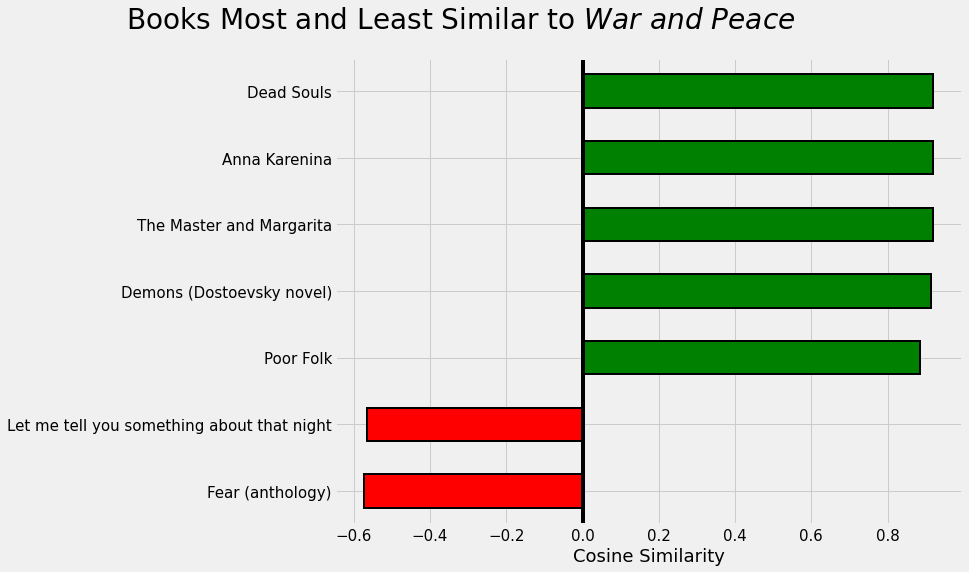

In [50]:
find_similar('War and Peace', book_weights, n = 5, plot = True)

In [53]:
find_similar('The Fellowship of the Ring', book_weights, n = 5)

Books closest to The Fellowship of the Ring.

Book: The Fellowship of the Ring   Similarity: 1.0
Book: The Silmarillion             Similarity: 0.96
Book: The Return of the King       Similarity: 0.95
Book: The Two Towers               Similarity: 0.92
Book: Beren and Lúthien            Similarity: 0.89


It doesn't work perfectly for every book as we can see.

In [54]:
find_similar('Artificial Intelligence: A Modern Approach', book_weights, n = 5)

Books closest to Artificial Intelligence: A Modern Approach.

Book: Artificial Intelligence: A Modern Approach   Similarity: 1.0
Book: Computer Graphics: Principles and Practice   Similarity: 0.97
Book: TCP/IP Illustrated                           Similarity: 0.96
Book: Rebel Code                                   Similarity: 0.96
Book: The Rootkit Arsenal                          Similarity: 0.95


In [55]:
find_similar('Weapons of Math Destruction', book_weights, n = 5)

Books closest to Weapons of Math Destruction.

Book: Weapons of Math Destruction             Similarity: 1.0
Book: The Alchemy of Race and Rights          Similarity: 0.96
Book: Affirmative Action Around the World     Similarity: 0.95
Book: Race: The Reality of Human Difference   Similarity: 0.95
Book: History's Memory                        Similarity: 0.95


In [56]:
find_similar('Bully for Brontosaurus', book_weights, n = 5)

Books closest to Bully for Brontosaurus.

Book: Bully for Brontosaurus                               Similarity: 1.0
Book: Monkey Girl                                          Similarity: 0.97
Book: Eight Little Piggies                                 Similarity: 0.97
Book: Leonardo's Mountain of Clams and the Diet of Worms   Similarity: 0.97
Book: I Have Landed                                        Similarity: 0.96


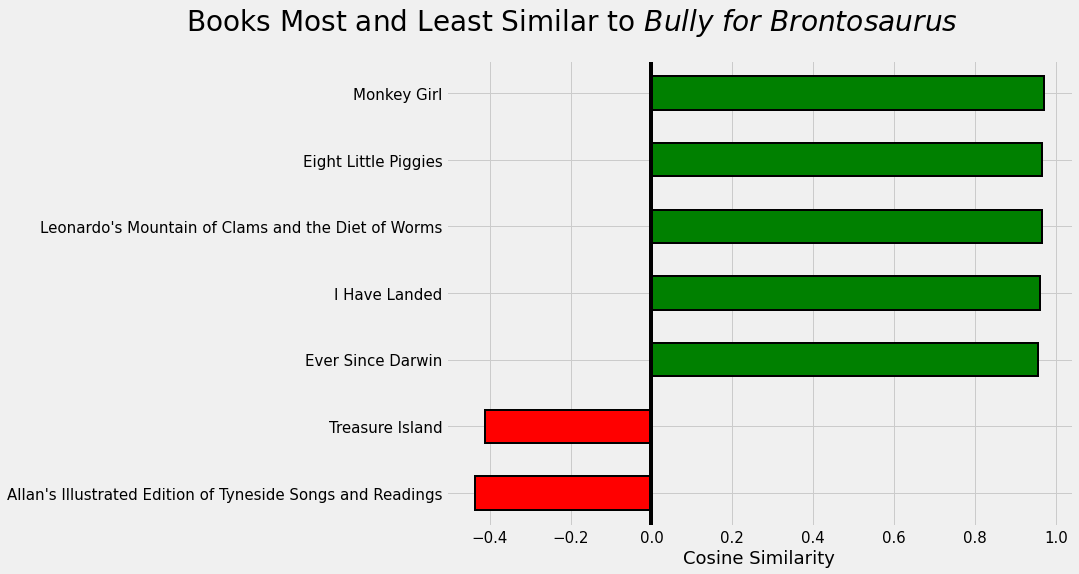

In [57]:
find_similar('Bully for Brontosaurus', book_weights, n = 5, plot = True)

In [58]:
def extract_weights(name, model):
    """Extract weights from a neural network model"""
    
    # Extract weights
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    
    # Normalize
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    return weights

In [59]:
link_weights = extract_weights('link_embedding', model)

In [60]:
find_similar('science fiction', link_weights, index_name = 'page')

Pages closest to science fiction.

Page: science fiction                            Similarity: 1.0
Page: category:american science fiction novels   Similarity: 0.99
Page: ballantine books                           Similarity: 0.93
Page: tor books                                  Similarity: 0.92
Page: category:doubleday (publisher) books       Similarity: 0.91
Page: bantam books                               Similarity: 0.9
Page: victor gollancz ltd                        Similarity: 0.89
Page: fantasy                                    Similarity: 0.89
Page: anthology                                  Similarity: 0.88
Page: ace books                                  Similarity: 0.88


In [61]:
find_similar('biography', link_weights, index_name = 'page')

Pages closest to biography.

Page: biography                             Similarity: 1.0
Page: category:american non-fiction books   Similarity: 0.94
Page: non-fiction                           Similarity: 0.94
Page: autobiography                         Similarity: 0.94
Page: category:2003 books                   Similarity: 0.93
Page: category:english-language books       Similarity: 0.92
Page: category:2007 books                   Similarity: 0.91
Page: category:2005 books                   Similarity: 0.9
Page: category:2004 books                   Similarity: 0.89
Page: memoir                                Similarity: 0.89


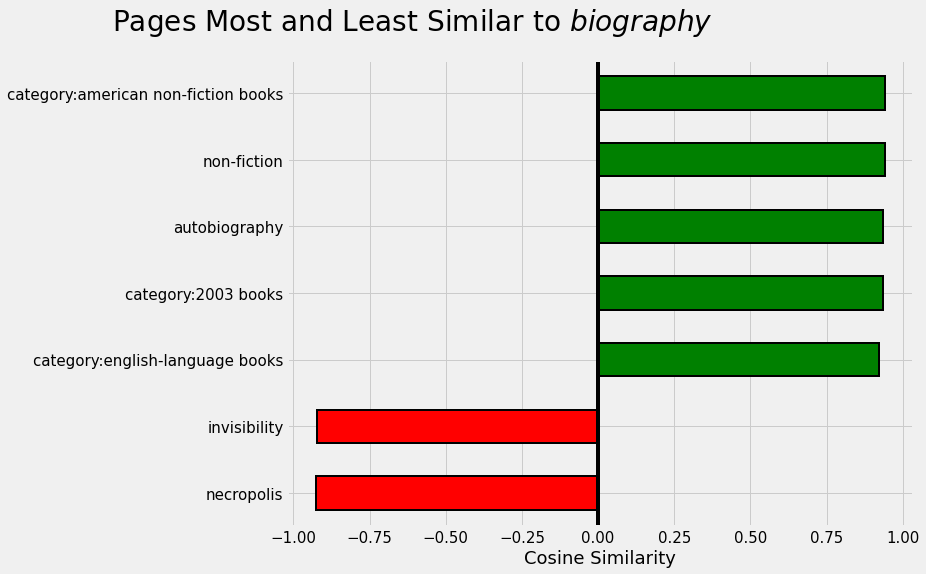

In [62]:
find_similar('biography', link_weights, index_name = 'page', n = 5, plot = True)

In [63]:
find_similar('new york city', link_weights, index_name = 'page', n = 5)

Pages closest to new york city.

Page: new york city                    Similarity: 1.0
Page: the new york times               Similarity: 0.96
Page: alfred a. knopf                  Similarity: 0.96
Page: category:random house books      Similarity: 0.95
Page: category:alfred a. knopf books   Similarity: 0.95


In [64]:
#Classification Model
model_class = book_embedding_model(50, classification = True)
gen = generate_batch(pairs, n_positive, negative_ratio=2, classification = True)

In [66]:
h = model_class.fit_generator(gen, epochs = 15, steps_per_epoch= len(pairs) // n_positive, verbose = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


In [67]:
model_class.save('first_attempt_class.h5')

In [68]:
book_weights_class = extract_weights('book_embedding', model_class)
book_weights_class.shape

(37020, 50)

In [69]:
find_similar('War and Peace', book_weights_class, n = 5)

Books closest to War and Peace.

Book: War and Peace              Similarity: 1.0
Book: Doctor Zhivago (novel)     Similarity: 0.77
Book: Anna Karenina              Similarity: 0.76
Book: The Master and Margarita   Similarity: 0.71
Book: The Brothers Karamazov     Similarity: 0.7


In [70]:
find_similar('The Fellowship of the Ring', book_weights_class, n = 5)

Books closest to The Fellowship of the Ring.

Book: The Fellowship of the Ring   Similarity: 1.0
Book: The Two Towers               Similarity: 0.92
Book: The Return of the King       Similarity: 0.86
Book: The Children of Húrin        Similarity: 0.85
Book: The Fall of Gondolin         Similarity: 0.83


In [71]:
find_similar('The Better Angels of Our Nature', book_weights_class, n = 5)

Books closest to The Better Angels of Our Nature.

Book: The Better Angels of Our Nature                                     Similarity: 1.0
Book: Bullshit Jobs                                                       Similarity: 0.74
Book: Quiet: The Power of Introverts in a World That Can't Stop Talking   Similarity: 0.72
Book: The God Delusion                                                    Similarity: 0.72
Book: The Moral Landscape                                                 Similarity: 0.71


In [72]:
link_weights_class = extract_weights('link_embedding', model_class)

In [73]:
find_similar('the washington post', link_weights_class, index_name = 'page', n = 5)

Pages closest to the washington post.

Page: the washington post   Similarity: 1.0
Page: los angeles times     Similarity: 0.96
Page: the new york times    Similarity: 0.93
Page: new york times        Similarity: 0.92
Page: washington post       Similarity: 0.92


In [74]:
find_similar('category:almanacs', link_weights_class, index_name = 'page', n = 5)

Pages closest to category:almanacs.

Page: category:almanacs                            Similarity: 1.0
Page: almanac                                      Similarity: 0.75
Page: united states government publishing office   Similarity: 0.64
Page: extremist                                    Similarity: 0.62
Page: 1852 in literature                           Similarity: 0.62


In [75]:
find_similar('richard dawkins', link_weights_class, index_name = 'page', n = 5)

Pages closest to richard dawkins.

Page: richard dawkins     Similarity: 1.0
Page: natural selection   Similarity: 0.78
Page: stephen jay gould   Similarity: 0.77
Page: evolution           Similarity: 0.77
Page: michael ruse        Similarity: 0.76


In [78]:
pip install umap-learn

     |████████████████████████████████| 86 kB 3.7 MB/s 
     |████████████████████████████████| 1.1 MB 21.8 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=1aa4b3e02c493e77acdb91b9976b79de6af5f8c4ff1c688af68b38e18b4857f4
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=d6f7b3b2b3ea0497f10b2f81bd327703461e2db52129bb960f2fb7e59d4b7063
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


In [79]:
#Visualizations
from sklearn.manifold import TSNE
from umap import UMAP

In [80]:
def reduce_dim(weights, components = 3, method = 'tsne'):
    """Reduce dimensions of embeddings"""
    if method == 'tsne':
        return TSNE(components, metric = 'cosine').fit_transform(weights)
    elif method == 'umap':
        # Might want to try different parameters for UMAP
        return UMAP(n_components=components, metric = 'cosine', 
                    init = 'random', n_neighbors = 5).fit_transform(weights)

In [81]:
book_r = reduce_dim(book_weights_class, components = 2, method = 'tsne')
book_r.shape

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


(37020, 2)

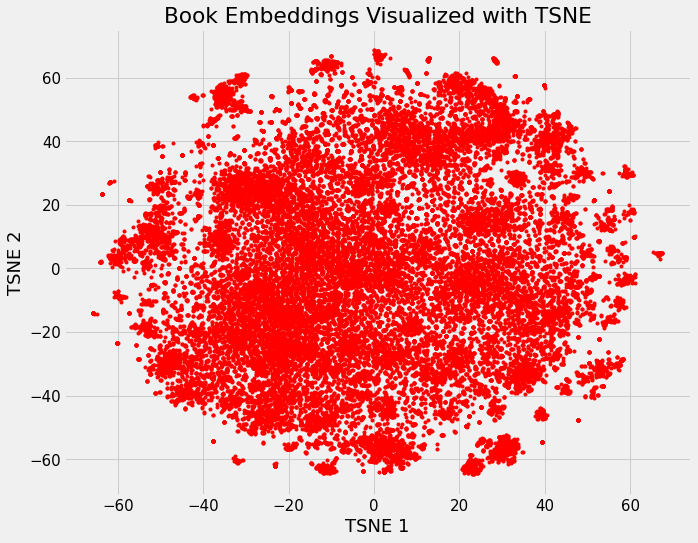

In [82]:
InteractiveShell.ast_node_interactivity = 'last'

plt.figure(figsize = (10, 8))
plt.plot(book_r[:, 0], book_r[:, 1], 'r.')
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Book Embeddings Visualized with TSNE');

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


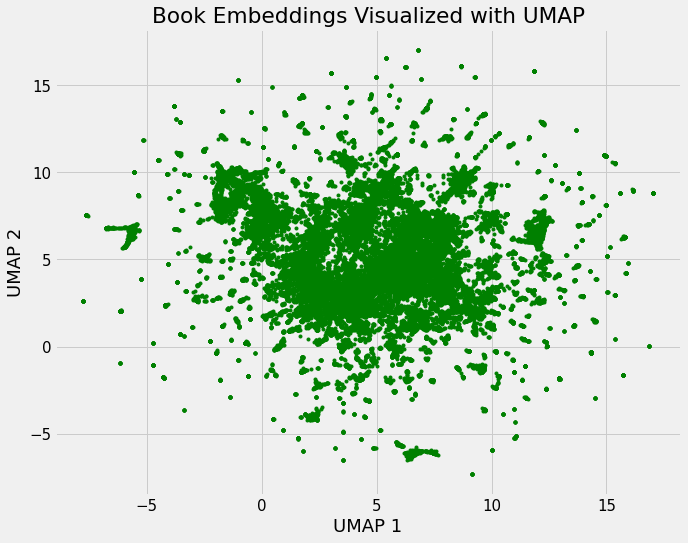

In [83]:
book_ru = reduce_dim(book_weights_class, components = 2, method = 'umap')

plt.figure(figsize = (10, 8))
plt.plot(book_ru[:, 0], book_ru[:, 1], 'g.');
plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2'); plt.title('Book Embeddings Visualized with UMAP');

In [84]:
info = list(chain(*[set(book[1]) for book in books]))
info_counts = count_items(info)
list(info_counts.items())[:10]

[('name', 36400),
 ('author', 35557),
 ('language', 32869),
 ('country', 30693),
 ('publisher', 30618),
 ('image', 28751),
 ('pages', 26090),
 ('media_type', 26016),
 ('genre', 25966),
 ('isbn', 24934)]

In [85]:
genres = [book[1].get('genre', 'None').lower() for book in books]

# Remove genres not found
genre_counts = count_items(genres)
del genre_counts['none']
list(genre_counts.items())[:10]

[('science fiction', 2177),
 ('novel', 1641),
 ('non-fiction', 1270),
 ('fantasy', 974),
 ('fantasy novel', 780),
 ('historical novel', 582),
 ('science fiction novel', 571),
 ('fiction', 559),
 ('crime novel', 424),
 ("children's novel", 313)]

In [86]:
# Include 10 most popular genres
genre_to_include = list(genre_counts.keys())[:10]

In [87]:
idx_include = []
genres = []

for i, book in enumerate(books):
    if 'genre' in book[1].keys():
        if book[1]['genre'].lower() in genre_to_include:
            idx_include.append(i)
            genres.append(book[1]['genre'].capitalize())
            
len(idx_include)

9291

In [88]:
ints, gen = pd.factorize(genres)
gen[:5]

array(['Science fiction', 'Novel', 'Non-fiction', 'Fiction',
       'Historical novel'], dtype=object)

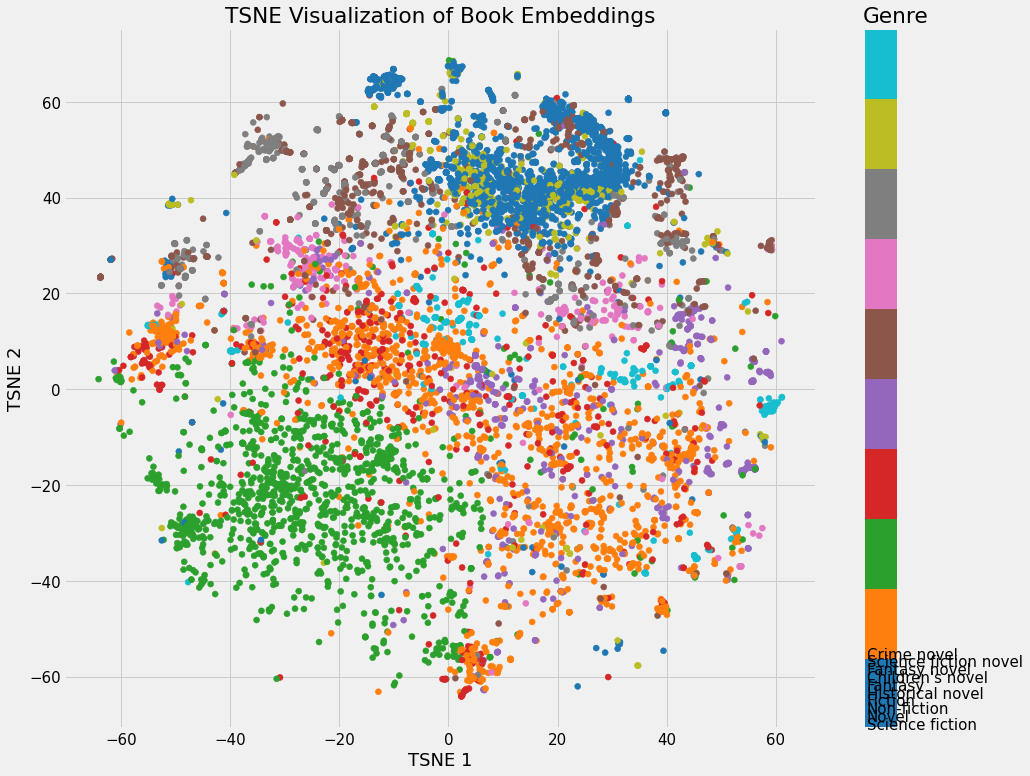

In [93]:
plt.figure(figsize = (15, 12))

# Plot embedding
plt.scatter(book_r[idx_include, 0], book_r[idx_include, 1], 
            c = ints, cmap = plt.cm.tab10)

# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.set_ticks([])
for j, lab in enumerate(gen):
    cbar.ax.text(1, (2 * j + 1) / ((10) * 2), lab, ha='left', va='center')
cbar.ax.set_title('Genre', loc = 'left')


plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('TSNE Visualization of Book Embeddings');

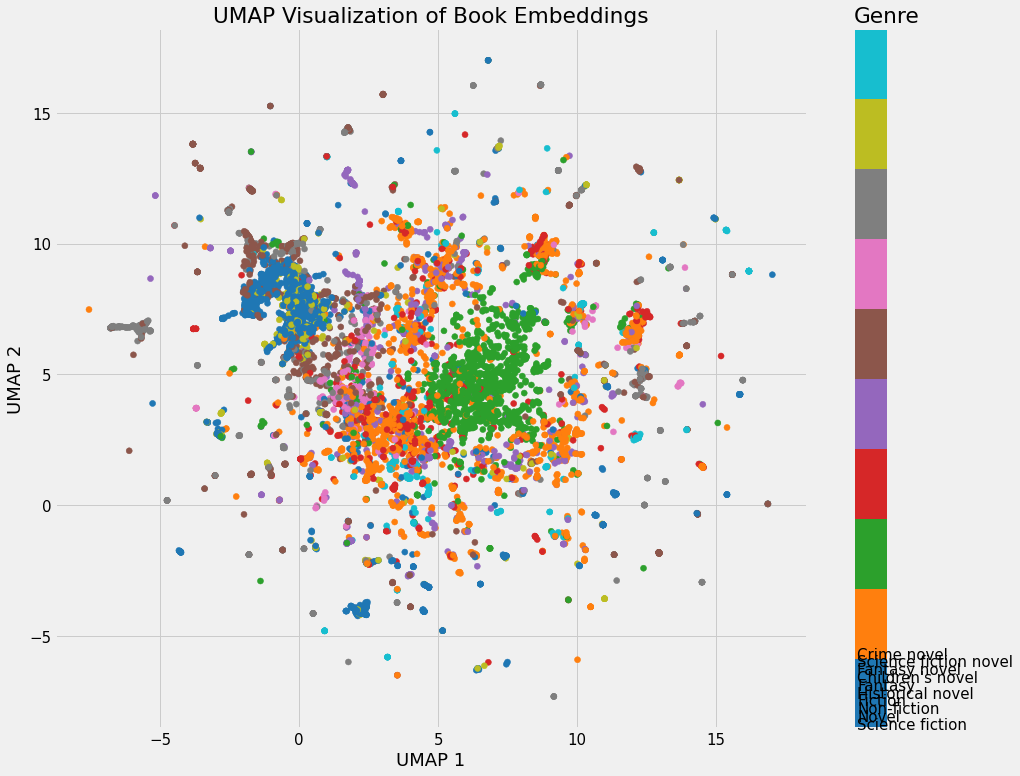

In [94]:
plt.figure(figsize = (15, 12))

# Plot embedding
plt.scatter(book_ru[idx_include, 0], book_ru[idx_include, 1], 
            c = ints, cmap = plt.cm.tab10)

# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.set_ticks([])
for j, lab in enumerate(gen):
    cbar.ax.text(1, (2 * j + 1) / ((10) * 2), lab, ha='left', va='center')
cbar.ax.set_title('Genre', loc = 'left')


plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2'); plt.title('UMAP Visualization of Book Embeddings');

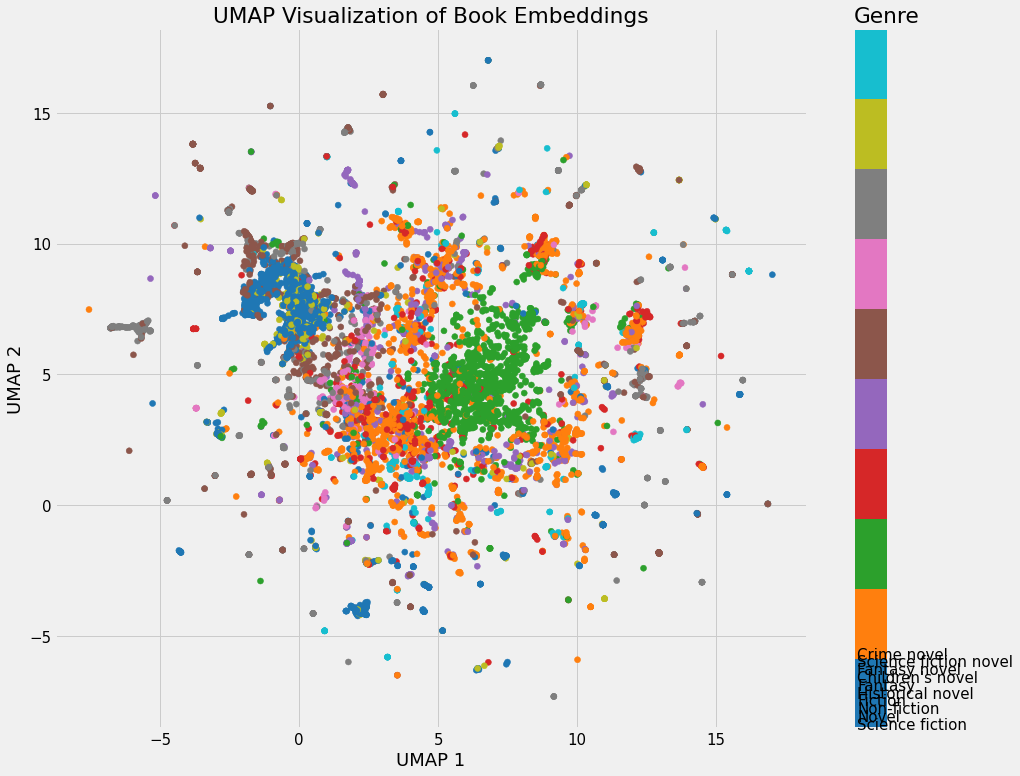

In [96]:
plt.figure(figsize = (15, 12))

# Plot embedding
plt.scatter(book_ru[idx_include, 0], book_ru[idx_include, 1], 
            c = ints, cmap = plt.cm.tab10)

# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.set_ticks([])
for j, lab in enumerate(gen):
    cbar.ax.text(1, (2 * j + 1) / ((10) * 2), lab, ha='left', va='center')
cbar.ax.set_title('Genre', loc = 'left')


plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2'); plt.title('UMAP Visualization of Book Embeddings');

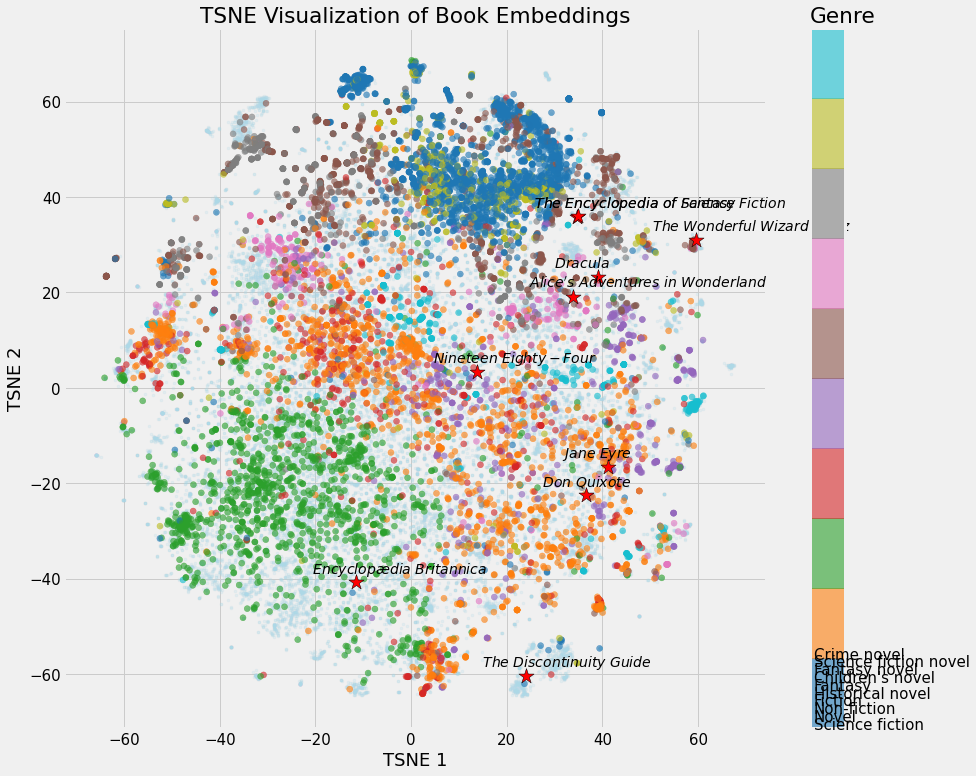

In [97]:
plt.figure(figsize = (14, 12))

# Plot all books
plt.scatter(book_r[:, 0], book_r[:, 1], marker = '.', color = 'lightblue', alpha = 0.2)

# Plot genres
plt.scatter(book_r[idx_include, 0], book_r[idx_include, 1], 
            c = ints, cmap = plt.cm.tab10, alpha = 0.6)

# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.set_ticks([])
for j, lab in enumerate(gen):
    cbar.ax.text(1, (2 * j + 1) / ((10) * 2), lab, ha='left', va='center')
    
cbar.ax.set_title('Genre', loc = 'left')
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('TSNE Visualization of Book Embeddings');

for book in list(wikilink_book_counts.keys())[:10]:
    
    x, y = book_r[book_index[book], 0], book_r[book_index[book], 1];
    # Italize book title using latex
    s =  ''.join([' $\it{' + word + '}$' for word in book.split()])
    _ = plt.scatter(x, y, s = 250, color = 'r',
                    marker = '*', edgecolor = 'k')
    _ = plt.text(x - 10, y + 2, s, fontsize = 14);

In [98]:
book_r[book_index['The Encyclopedia of Science Fiction']]

array([34.76843 , 35.894318], dtype=float32)

In [99]:
book_r[book_index['The Encyclopedia of Fantasy']]

array([34.841003, 35.918175], dtype=float32)

In [102]:
#Pages Visualization


In [113]:
link_r = reduce_dim(link_weights_class, components = 2, method = 'tsne')
link_r.shape

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


(41758, 2)

In [115]:
idx_to_include = [idx for link, idx in link_index.items() if 'category:' in link]

categories = []

for book in books:
    for link in book[2]:
        if 'category:' in link.lower():
            categories.append(link)
            
c_counts = count_items(categories)
list(c_counts.items())[:5]

[('Category:American science fiction novels', 1289),
 ('Category:American novels adapted into films', 1139),
 ('Category:Debut novels', 1072),
 ('Category:American fantasy novels', 1036),
 ('Category:American young adult novels', 956)]

In [116]:
idx = []

# Find the index of the most popular links
for link in list(c_counts.keys())[:10]:
    link_idx = link_index[link.lower()]
    
    # Find index of category 
    index = int(np.where(np.array(idx_to_include) == link_idx)[0])
    idx.append(index)

Text(0.5, 1.0, 'Wikilinks Category Embedding Visualized with TSNE')

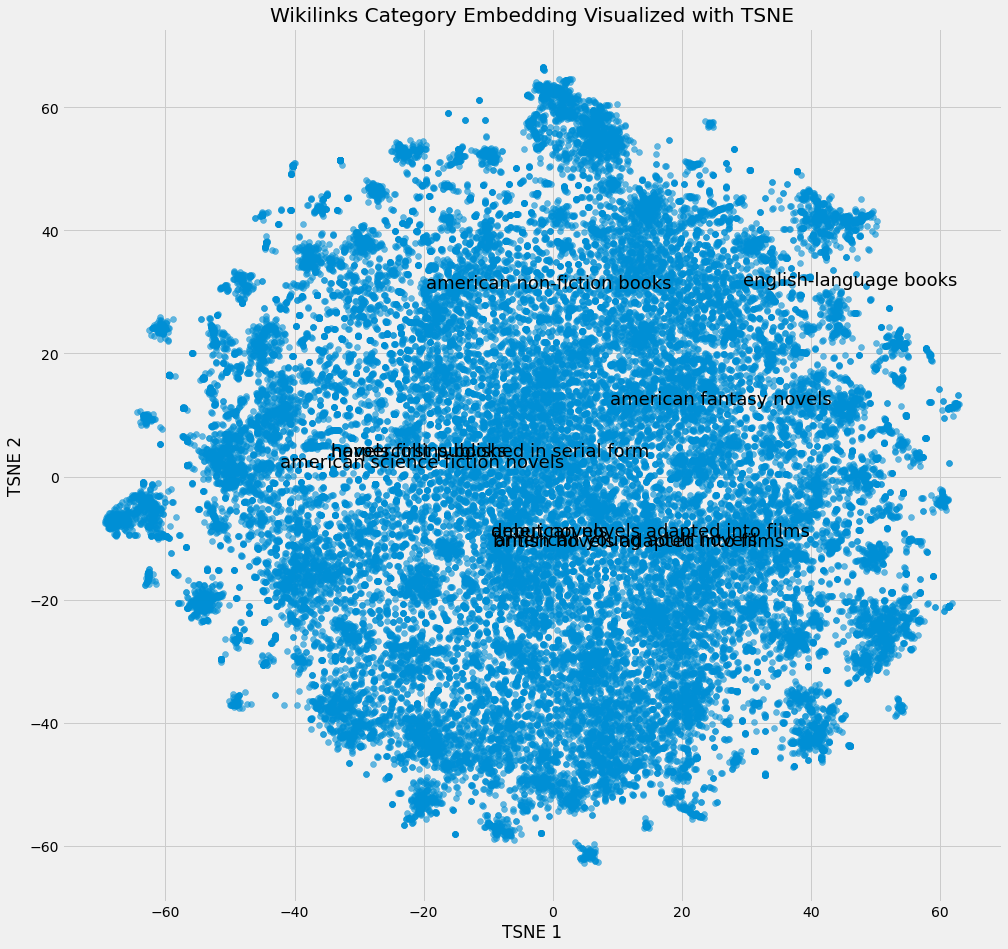

In [118]:
plt.figure(figsize = (15, 15))
plt.scatter(link_r[:, 0], link_r[:, 1], alpha = 0.6)

for i in idx:
    x, y = link_r[i, 0], link_r[i, 1]
    s = index_link[idx_to_include[i]].split(':')[-1]
    _ = plt.text(x, y, s, fontsize = 18);
    
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Wikilinks Category Embedding Visualized with TSNE')

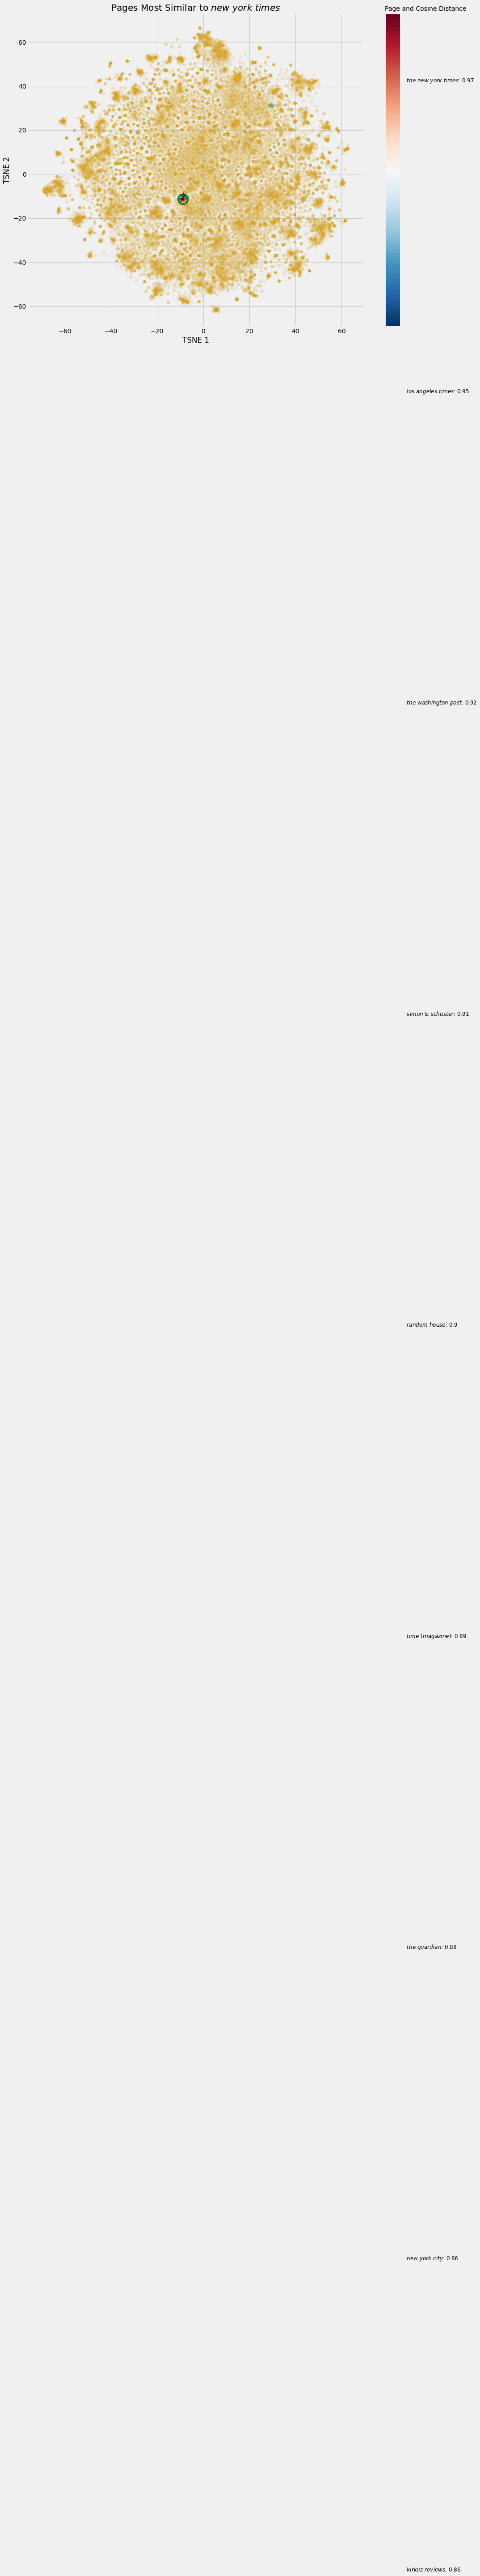

In [119]:
plot_closest('new york times', link_weights_class, 'page', 10, link_r)

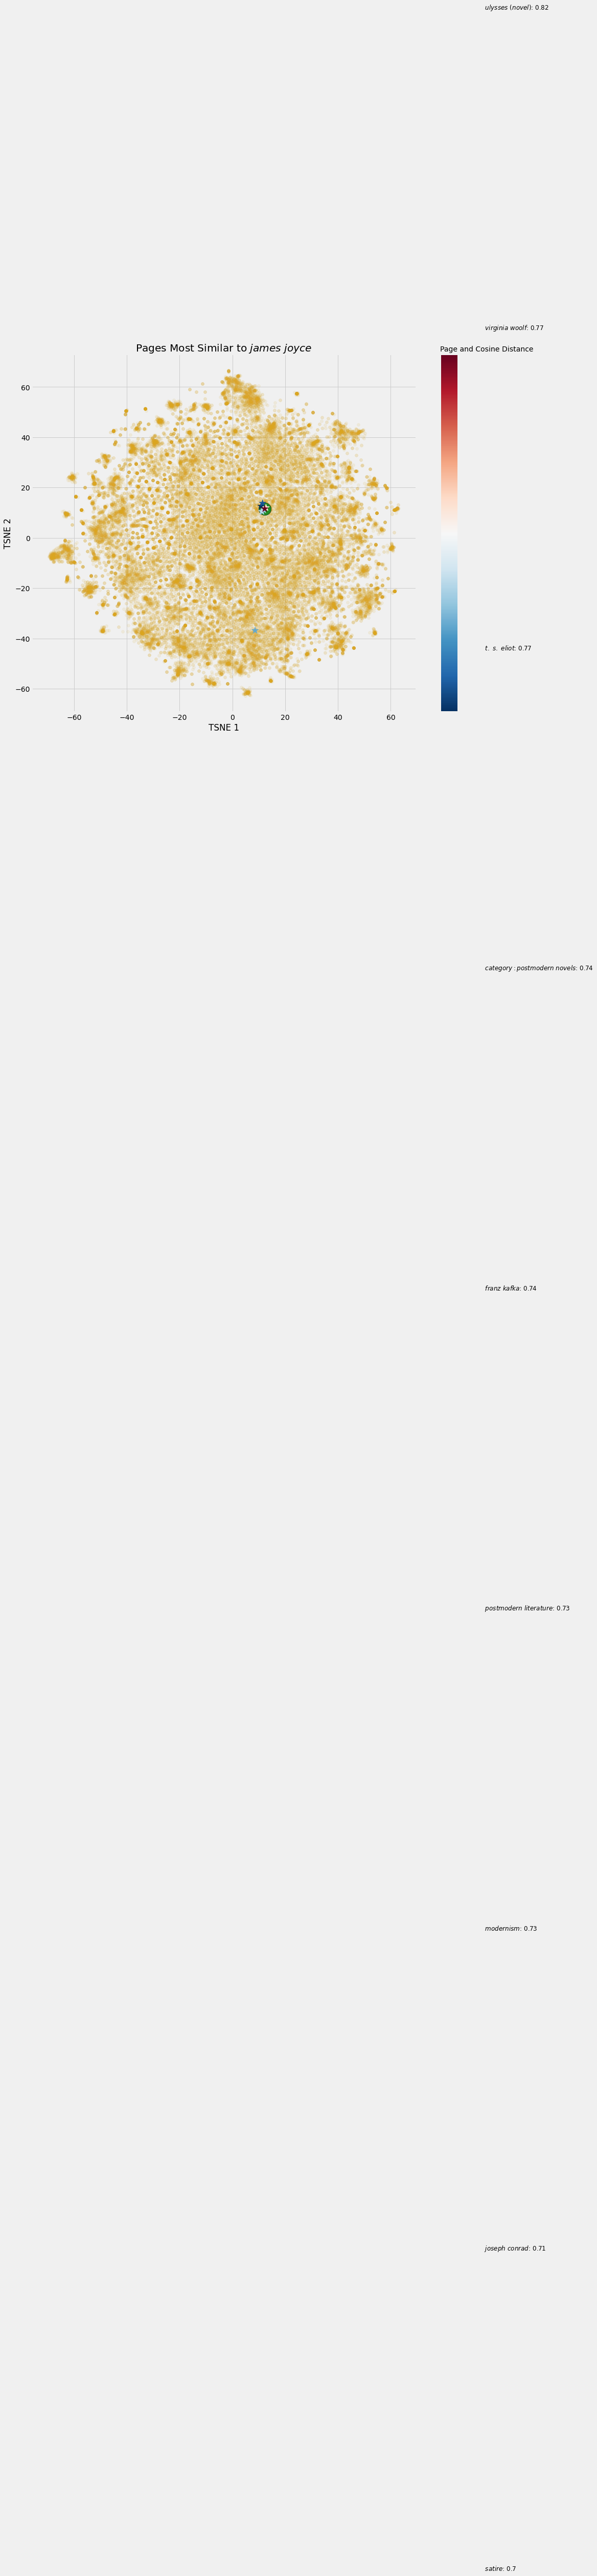

In [120]:
plot_closest('james joyce', link_weights_class, 'page', 10, link_r)

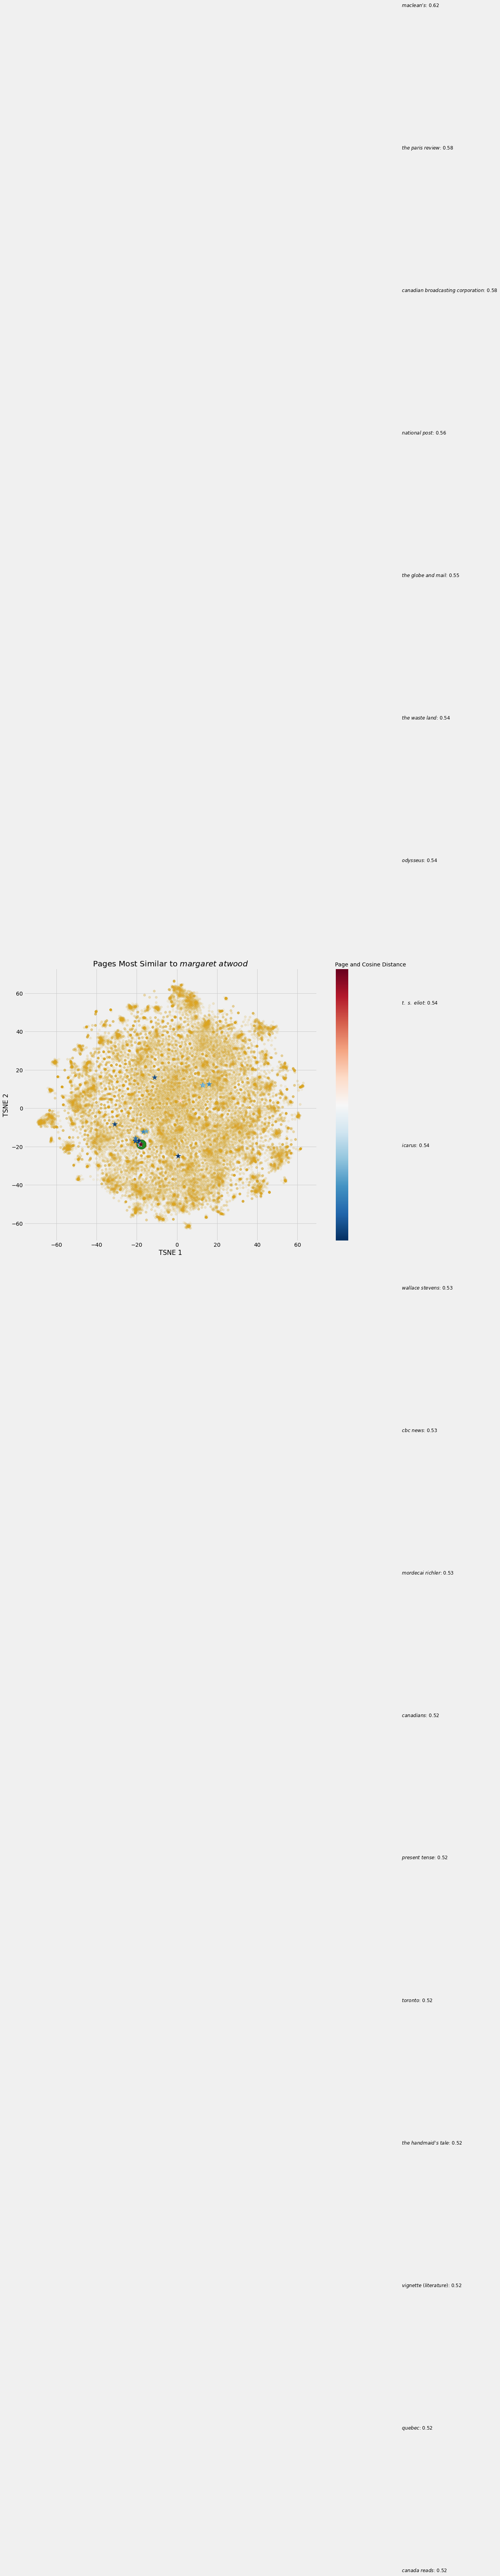

In [122]:
plot_closest('margaret atwood', link_weights_class, 'page', 20, link_r)

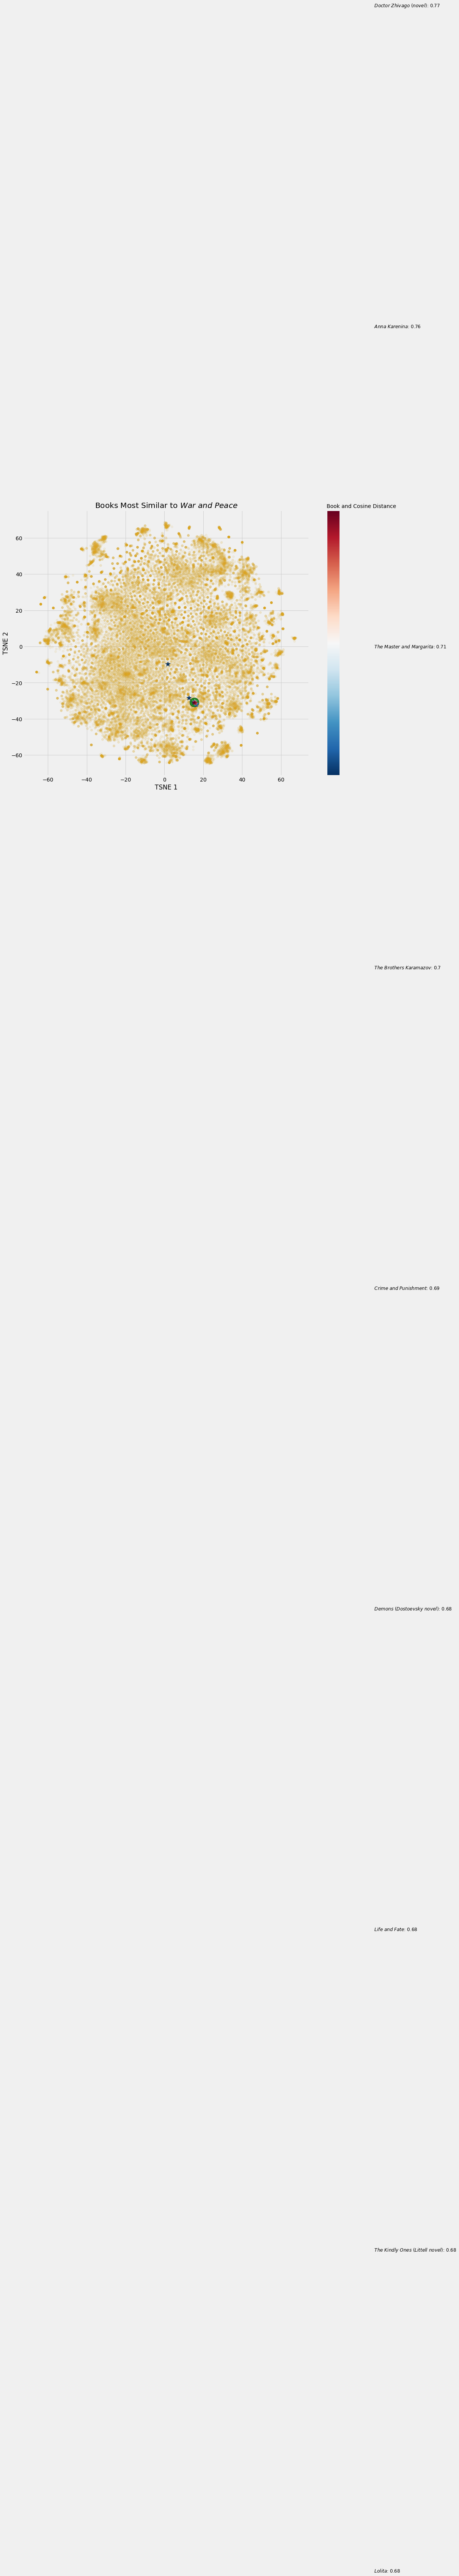

In [121]:
plot_closest('War and Peace', book_weights_class, 'book', 10, book_r)

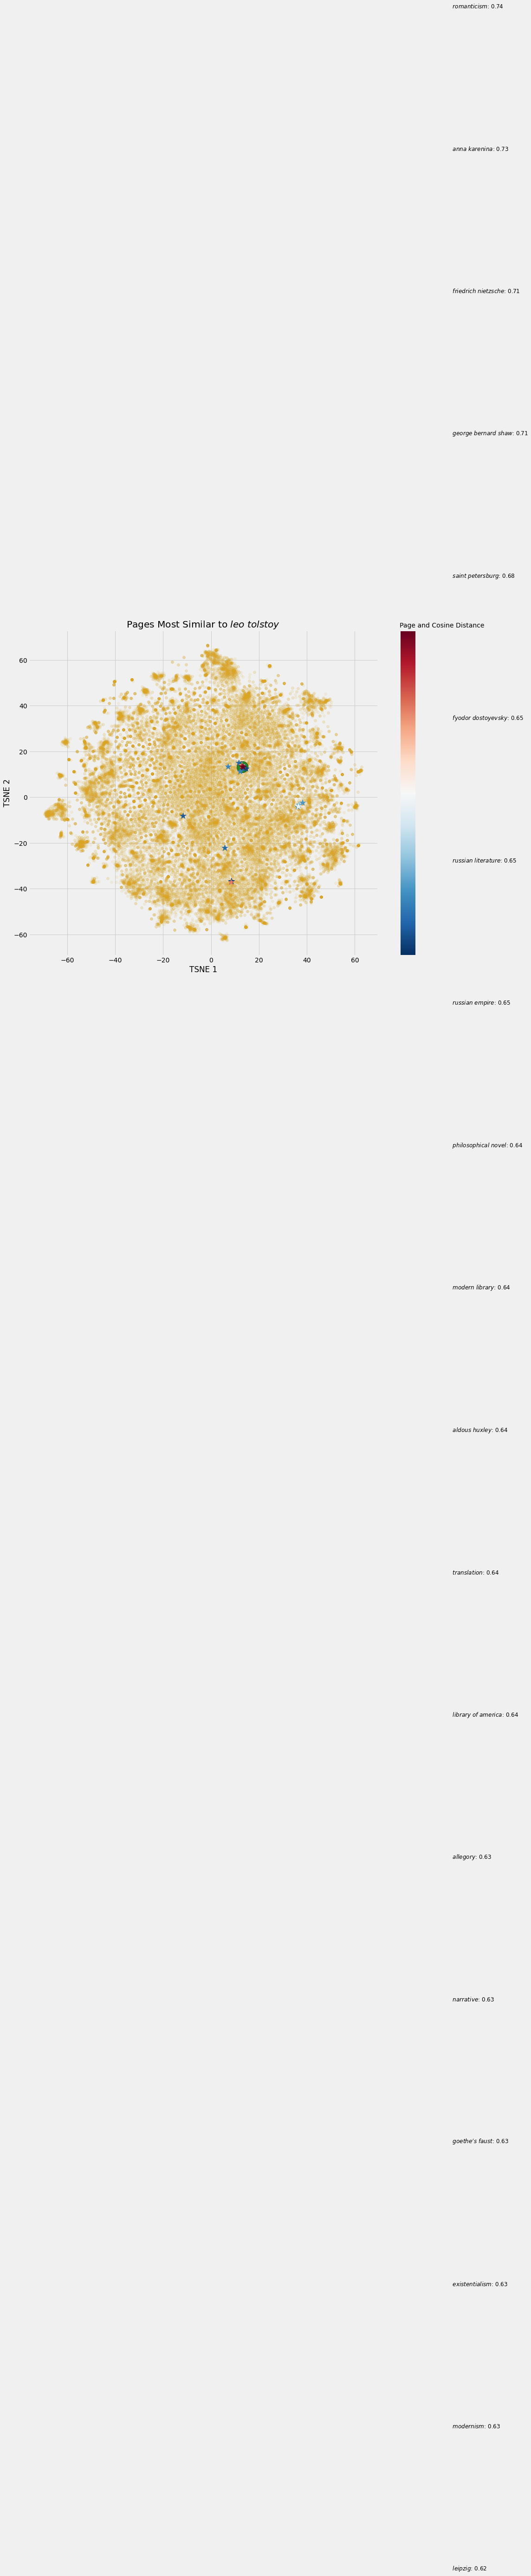

In [123]:
plot_closest('leo tolstoy', link_weights_class, 'page', 20, link_r)

In [124]:
#Plot Multiple Books and Pages
def plot_groups(items, weights, embed, index_name = 'book', n = 5):
    closest = []
    dists = []
    
    # Select index and reverse index
    if index_name == 'book':
        index = book_index
        rindex = index_book
    elif index_name == 'page':
        index = link_index
        rindex = index_link
    
    for item in items:
        d, c = find_similar(item, weights, index_name, n, return_dist = True)
        d = d[c]
        closest.extend(c)
        dists.extend(d)
        
    ax = plt.figure(figsize = (10, 8))
    p = plt.scatter(embed[:, 0], embed[:, 1], alpha = 0.2, marker = 'o', color =  'lightblue')

    cmap = plt.cm.get_cmap('tab10_r', len(items))
    color_list = []
    
    for i, item in enumerate(items):
         # Plot the item
        plt.scatter(embed[index[item], 0], embed[index[item], 1], 
                    s = 200, alpha = 0.4, edgecolor = 'k', color = cmap(i))
        color_list.extend(i for _ in range(n))
        
    p = plt.scatter(embed[closest, 0], embed[closest, 1], c = color_list, cmap = cmap, s = 150,
                    marker = '*', alpha = 0.8)

    
    cbar = plt.colorbar(p)
    cbar.set_ticks([])
    
    tick_labels = []
    # Tick labeling for colorbar
    for item in items:
        name_str = ''
        for word in item.split():
            # Title uses latex for italize
            name_str += ' $\it{' + word + '}$'
        tick_labels.append(name_str)
        
    for j, lab in enumerate(tick_labels):
        cbar.ax.text(1, (2 * j + 1) / (len(items) * 2), lab, ha='left', va='center', size = 12)
    cbar.ax.set_title(f'Highlighted {index_name.capitalize()}s', loc = 'left', size = 14)
    plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title(f'Embedded {index_name.capitalize()}s with Closest Neighbors');

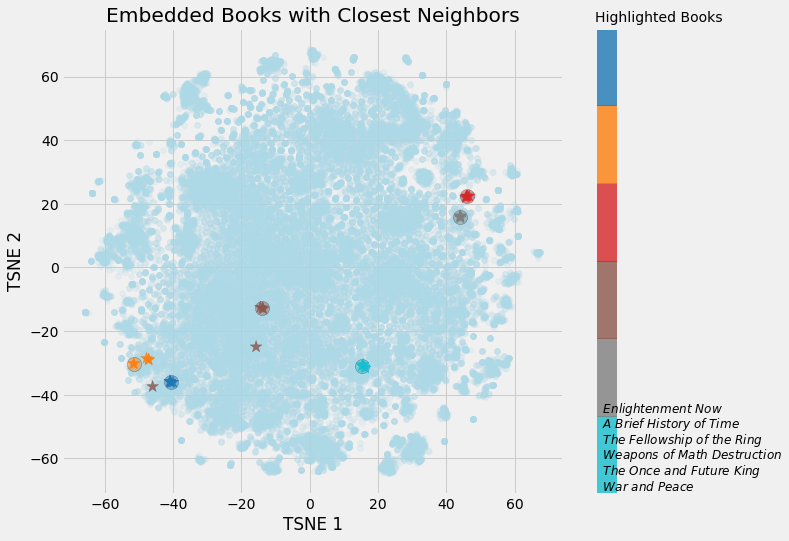

In [125]:
plot_groups(['War and Peace', "The Once and Future King", 
             "Weapons of Math Destruction", "The Fellowship of the Ring",
             "A Brief History of Time", "Enlightenment Now"],
            book_weights_class, book_r, 'book')

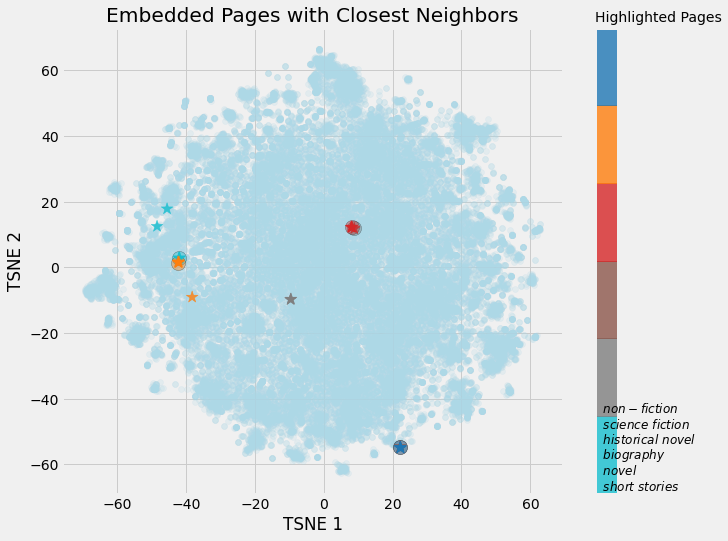

In [126]:
plot_groups(['short stories', 'novel',
            'biography', 'historical novel', 
             'science fiction', 'non-fiction'], 
            link_weights_class, link_r, 'page')

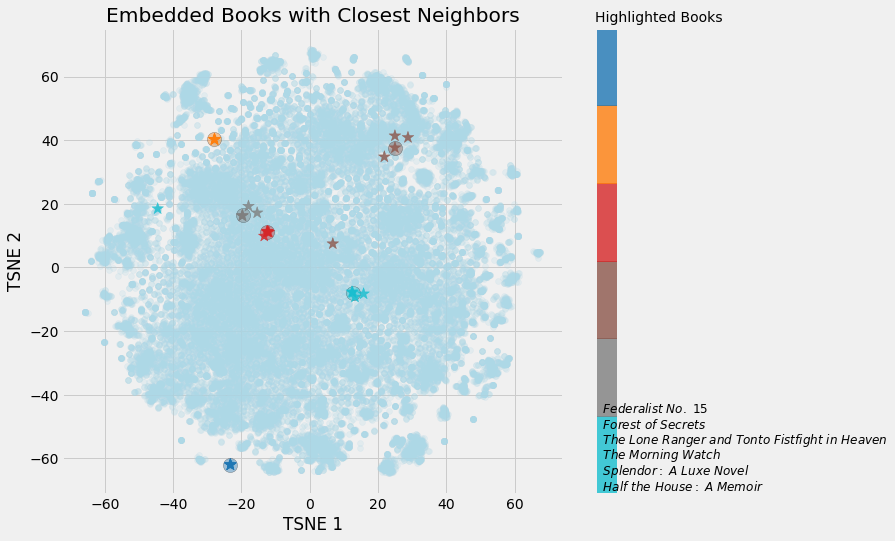

In [127]:
random.seed(150)
plot_groups(list(random.sample(book_index.keys(), 6)),
            book_weights_class, book_r, 'book')

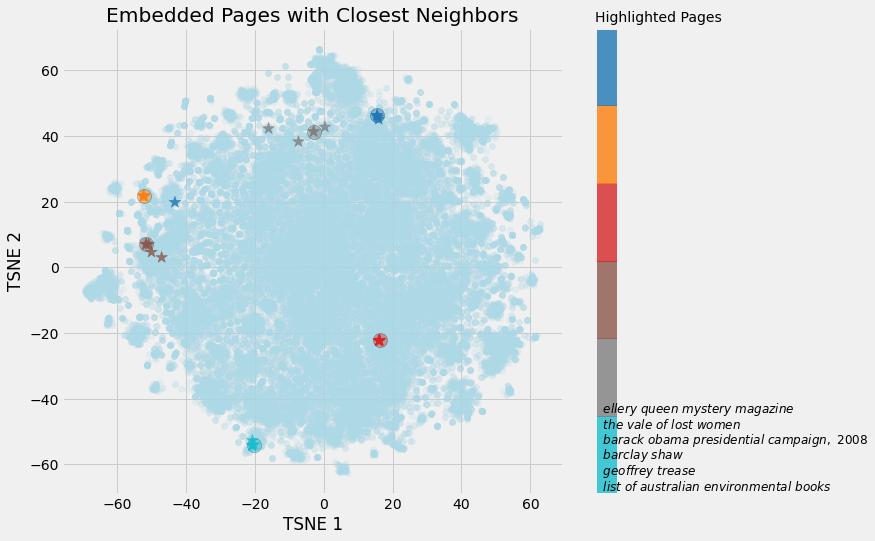

In [128]:
random.seed(150)
plot_groups(list(random.sample(link_index.keys(), 6)), link_weights_class, link_r, 'page')

In [130]:
%%capture
with open('link_names.tsv', 'w' , encoding = 'utf-8') as fout:
    for l in link_index.keys():
        fout.write(str(l))
        fout.write('\n')

In [131]:
import re
pattern = re.compile('[\\n]|<.*?>')
pattern.sub('', 'bill moushey \n < br >').strip()

'bill moushey'

In [132]:
import re
pattern = re.compile('[\\n]|<.*?>')

# Extract book metadata
authors = []
genres = []
pages = []
languages = []
countries = []
publishers = []


for book in books:
    info = book[1]
    for attr, l in zip(['author', 'genre', 'pages', 'langauge', 'country', 'publisher'],
                        [authors, genres, pages, languages, countries, publishers]):
        l.append(pattern.sub('', info.get(attr, 'None').lower()).strip())

book_info = pd.DataFrame({'author': authors, 'genre': genres, 'pages': pages,
                          'language': languages, 'country': countries,
                          'publisher': publishers}, index = list(book_index.keys()))

book_info = book_info.replace({'none': np.nan})
book_info.index.name = 'title'
book_info.head()

author  \
title                                              
Freud: His Life and His Mind  helen walker puner   
Blackbox (novel)                     nick walker   
My Real Children                       jo walton   
The Alleys of Eden            robert olen butler   
Day of the Dogs                   andrew cartmel   

                                                              genre  \
title                                                                 
Freud: His Life and His Mind                                    NaN   
Blackbox (novel)                                                NaN   
My Real Children              fantasy literature, alternate history   
The Alleys of Eden                                              NaN   
Day of the Dogs                                     science fiction   

                                           pages  language         country  \
title                                                                        
Freud: His Life and His Mind  288 (1959 edition)       NaN   united states   
Blackbox (novel)                             NaN       NaN  united kingdom   
My Real Children                         320 pp.       NaN   united states   
The Alleys of Eden                        251 pp       NaN   united states   
Day of the Dogs                              256       NaN             NaN   

                                    publisher  
title                                          
Freud: His Life and His Mind  dell publishing  
Blackbox (novel)                harpercollins  
My Real Children                    tor books  
The Alleys of Eden                        NaN  
Day of the Dogs                   black flame

In [133]:
book_info.to_csv('book_info.tsv', sep = '\t')

In [134]:
np.savetxt('book_embedding.tsv', book_weights_class, delimiter='\t')
np.savetxt('link_embedding.tsv', link_weights_class, delimiter='\t')

In [135]:
book_embedding = np.loadtxt('book_embedding.tsv', delimiter = '\t')
book_embedding.shape

(37020, 50)

I only had problems while plotting graphs and rest of the project was very fun and i learned a lot from it 
THANK YOU